In [1]:
import numpy as np
import requests, gzip, os, hashlib
import matplotlib.pyplot as plt
np.random.seed(1)
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
# FUNCTION TO INITIALIZE PARAMETERS
def initialize_parameters(n_x, n_h, n_y):
    """
    n_x -- number of input nodes
    n_h -- number of hidden nodes
    n_y -- number of output nodes

    Returns:
    W1 -- weight matrix of shape(n_h, n_x)
    b1 -- bias vector of shape(n_h, 1)
    W2 -- weight matrix of shape(n_y, n_h)
    b2 -- bias vector of shape(n_y, 1)
    """

    W1 = np.random.randn(n_h, n_x) * 0.01
    b1 = np.zeros((n_h, 1))
    W2 = np.random.randn(n_y, n_h) * 0.01
    b2 = np.zeros((n_y, 1))

    parameters = {
                  "W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2
                  }
    
    return parameters

In [3]:
# ALL THE ACTIVATION FUNCTIONS WITH THEIR DERIVATIVES FOR BACKWARD PROP.

def relu(Z):
    A = np.maximum(0, Z)
    cache = Z

    return A, cache

def relu_backward(dA, cache):
    Z = cache
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0

    return dZ


def softmax(Z):
    A = np.exp(Z) / np.sum(np.exp(Z), axis = 0)
    cache = Z
    return A, cache

def softmax_backward(dA, cache):
    Z = cache
    s = np.exp(Z) / np.sum(np.exp(Z), axis = 0)
    dZ = dA * s * (1 - s)

    return dZ

In [4]:
# FUNCTIONS FOR FORWARD PROPAGATION

def linear_forward(A, W, b):
    """
    Implement the linear part of a layer's forward propagation.

    Arguments:
    A -- Activations from the previous layers (or input layer)
    W -- Weights matrix
    b -- Bias vector

    Returns:
    Z -- The input of the activation function, also called pre-activation parameter
    cache -- A python tuple containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """

    Z = np.dot(W, A) + b

    cache = (A, W, b)

    return Z, cache



def linear_activation_forward(A_prev, W, b, activation):
    """
    A_prev -- activations from previous layer (or input layer): (size of previous layer, number of examples)
    W -- Weight matrix: numpy array of shape (size of current layer, size of previos layer)
    b -- Bias Vector: numpy array of shape (size of current layer, 1)
    activation -- The activation to be used in this layer, stored as string: "relu" or "softmax"

    Returns:
    A -- The output of the activation function, also called post-activation value
    cache -- A python tuple containing "linear_cache" and "activation cache";
             Sroted for computing the backward propagation efficiently
    """

    if activation == "relu":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = relu(Z)
    
    elif activation == "softmax":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = softmax(Z)
    
    cache = (linear_cache, activation_cache)

    return A, cache

In [5]:
# FUNCTIONS FOR BACKWARD PROPAGATION

def linear_backward(dZ, cache):
    """
    Implement the linear portion of back propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """

    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1/m) * np.dot(dZ, A_prev.T)
    db = (1/m) * np.sum(dZ, axis = 1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)

    return dA_prev, dW, db


def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR --> ACTIVATION layer.

    Argumenst:
    dA -- post-activation gradient for current layer 1
    cache -- tuple of values (linear_cache, activation cache) we store for computing backward propagation efficiently
    activation -- The activation to be used in this layer, stored as string: "relu" or "softmax"

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """

    linear_cache, activation_cache = cache

    if activation == "relu":
        dZ = relu_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    elif activation == "softmax":
        dZ = softmax_backward(dA, activation_cache)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    return dA_prev, dW, db

In [6]:
# COST FUNCTION

def compute_cost(AL, Y):
    """
    Using mean square error as the cost function.

    Arguments:
    AL -- Probability vector corresponding to the label predictions of output layer
    Y -- True Label of the corresponding example

    Returns: 
    cost -- Mean Squared Error cost
    """

    m = Y.shape[1]
    cost = (1/(2*m)) * np.sum(np.square(AL - Y))

    return cost

In [7]:
# UPDATE PARAMETERS

def update_parameters(parameters, grads, learning_rate):
    """
    Update parameters using gradient descent

    Arguments:
    parameters -- python dictionary containing the parameters
    grads -- python dictionary containing the gradients

    Returns:
    parameters -- python dictionary containing the updated parameters
    """

    L = len(parameters) // 2

    for l in range(L):
        parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - learning_rate*grads["dW" + str(l+1)]
        parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - learning_rate*grads["db" + str(l+1)]
    
    return parameters

In [8]:
# FORWARD MODEL TO PREDICT FOR TEST SET

def model_forward(X, parameters):
    """
    Implement forward propagarion for the model

    Arguments:
    X -- data, numpy array of shape (input size, number of examples)
    parameters -- output of initialize_parameters()

    Returns:
    AL -- last post-activation value
    caches -- List of caches
    """

    caches = []
    A = X
    L = len(parameters) // 2        # number of layers in the neural network

    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    for l in range(1, L):
        A_prev = A
        A, cache = linear_activation_forward(A_prev, parameters["W" + str(l)], parameters["b" + str(l)], activation = "relu")
        caches.append(cache)
    
    # Implement LINEAR -> SOFTMAX. Add "cache" to the "caches" list.
    AL, cache = linear_activation_forward(A, parameters["W" + str(L)], parameters["b" + str(L)], activation = "softmax")
    caches.append(cache)

    return AL, caches

In [80]:
# FUNCTION TO PREDICT THE OUTPUT FOR TEST SET

def predict(X, y, parameters):
    """
    This function is used to perdict the results of a neural network.

    Arguments:
    X -- data set of examples you would like to label
    parameters -- parameters of the trained model

    Returns:
    probas -- The output of the vectors of probablities
    p -- Predictions of the given dataset X
    """

    m = X.shape[1]
    n = len(parameters) // 2        # number of layers in the neural network
    p = np.zeros((1, m))

    # FORWARD PROPAGATION
    probas, caches = model_forward(X, parameters)

    # CONVERT PROBAS TO 0/1 PREDICTIONS
    check = np.argmax(probas, axis = 0)
    for i in range(0, probas.shape[1]):
        if check[i] == y[i]:
            p[0, i] = 1
        else:
            p[0, i] = 0
    
    print("Accuracy: " + str(np.sum(p)/m))

    return p, probas

## Load Dataset, preprocess it, make it into desired shape

In [10]:
# Fetch MNIST data
path = '/content/'

def fetch(url):
    fp = os.path.join(path, hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            data = f.read()
    else:
        with open(fp, "wb") as f:
            data = requests.get(url).content
            f.write(data)
    return np.frombuffer(gzip.decompress(data), dtype = np.uint8).copy()

X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28*28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

In [11]:
# Explore the dataset
# print(X_train.shape)
m_train = X_train.shape[0]
num_px = X_train.shape[1]
m_test = X_test.shape[0]

print('Number of training examples: ' + str(m_train))
print('Number of testing examples: ' + str(m_test))
print('Each image is of siz: (' + str(num_px) + "," + str(num_px) + ")")
print("X_train shape: " + str(X_train.shape))
print("Y_train shape: " + str(Y_train.shape))
print("X_test shape: " + str(X_test.shape))
print("Y_test shape: " + str(Y_test.shape))

Number of training examples: 60000
Number of testing examples: 10000
Each image is of siz: (28,28)
X_train shape: (60000, 28, 28)
Y_train shape: (60000,)
X_test shape: (10000, 784)
Y_test shape: (10000,)


In [12]:
# Reshape the training and test set
X_train_flatten = X_train.reshape(X_train.shape[0], -1).T
X_test_flatten = X_test.reshape(X_test.shape[0], -1).T

# Standardize data to have feature values between 0 and 1
X_train = X_train_flatten / 255.
X_test = X_test_flatten / 255.

print('X_train shape: ' + str(X_train.shape))
print('X_test shape: ' + str(X_test.shape))

X_train shape: (784, 60000)
X_test shape: (784, 10000)


In [13]:
Y_train

array([5, 0, 4, ..., 5, 6, 8], dtype=uint8)

The Y_train and the Y_test are the list of integers. But the final layer of our neural network has 10 nodes with softmax as the activation function. So we need to convert the Y_train and Y_test to one hot encoded form of length 10. This will ensure that the ith index has 1 corresponding to the number. 

e.g. 6 will be represented as:
[0, 0, 0, 0, 0, 0, 1, 0, 0, 0]

In [14]:
# Reshape the training and test set Y
train_y = np.zeros((10, 60000))
for i, y in enumerate(Y_train):
    train_y[y][i] = 1

test_y = np.zeros((10, 10000))
for i, y in enumerate(Y_test):
    test_y[y][i] = 1

In [15]:
print(train_y.shape)
print(test_y.shape)

(10, 60000)
(10, 10000)


In [16]:
# Print first 10 Y_train and the encoded matrix
print(Y_train[:10])
print(train_y[:, :10])

[5 0 4 1 9 2 1 3 1 4]
[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [17]:
# Print first 10 Y_test and the encoded matrix
print(Y_test[:10])
print(test_y[:, :10])

[7 2 1 0 4 1 4 9 5 9]
[[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 1.]]


### Layout of the model
The model consists of 2 layers(3 including the input layer).
- Input layer: 28*28 image flattened making 784 nodes in the input layer
- Hidden layer: Taking 128 nodes in the hidden layer
- Output layer: 10 outputs with softmax activation

The model looks something like this:


LINEAR --> RELU(ACTIVATION) --> LINEAR --> SOFTMAX(ACTIVATION)

In [18]:
# CONSTANTS DEFINING THE MODEL
n_x = 784   # number of input nodes
n_h = 128   # number of hidden nodes
n_y = 10    # number of output nodes

layer_dims = (n_x, n_h, n_y)

In [19]:
def model(X, Y, layer_dims, learning_rate = 0.01, num_iterations = 1000, print_cost = False):

    np.random.seed(1)
    grads = {}
    costs = []          # to keep track of cost
    m = X.shape[1]      # number of examples
    (n_x, n_h, n_y) = layer_dims

    # Initialize parameters dictionary
    parameters = initialize_parameters(n_x, n_h, n_y)

    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']

    for i in range(0, num_iterations):
        # FORWARD PROPAGATION
        # LINEAR --> RELU --> LINEAR --> SOFTMAX
        A1, cache1 = linear_activation_forward(X, W1, b1, activation="relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation="softmax")

        # COMPUTE COST
        cost = compute_cost(A2, Y)

        # INITIALIZING BACKWARD PROPAGATION
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))

        # BACKWARD PROPAGATION
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation="softmax")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation="relu")

        grads["dW1"] = dW1
        grads["db1"] = db1
        grads["dW2"] = dW2
        grads["db2"] = db2
        
        # UPDATE PARAMETERS
        parameters = update_parameters(parameters, grads, learning_rate)

        # RETRIEVE W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]

        # PRINT THE COST EVERY 50 TRAINING EXAMPLE
        if print_cost and i%50 == 0:
            print('Cost after iteration {}: {}'.format(i, np.squeeze(cost)))
        if print_cost and i%50 == 0:
            costs.append(cost)
    
    # PLOT THE COST
    plt.plot(np.squeeze(costs))
    plt.xlabel('Iterations (per fifty)')
    plt.ylabel('Cost')
    plt.title('Learning rate = ' + str(learning_rate))
    plt.show()

    return parameters

Cost after iteration 0: 0.4499763042674335
Cost after iteration 50: 0.44938039479672837
Cost after iteration 100: 0.44864485258287756
Cost after iteration 150: 0.447613825013837
Cost after iteration 200: 0.44608789363912127
Cost after iteration 250: 0.44379413659836453
Cost after iteration 300: 0.44034603019926
Cost after iteration 350: 0.4352063154122122
Cost after iteration 400: 0.4277132728787733
Cost after iteration 450: 0.4172615904584523
Cost after iteration 500: 0.40355289388067894
Cost after iteration 550: 0.3866360146268962
Cost after iteration 600: 0.3668033249862718
Cost after iteration 650: 0.3447026163333163
Cost after iteration 700: 0.3214797301928966
Cost after iteration 750: 0.2985160754401052
Cost after iteration 800: 0.2768985245021714
Cost after iteration 850: 0.2571884035651801
Cost after iteration 900: 0.2395583128313595
Cost after iteration 950: 0.22397291295370425
Cost after iteration 1000: 0.21029009668874346
Cost after iteration 1050: 0.19831751486210192
Cost a

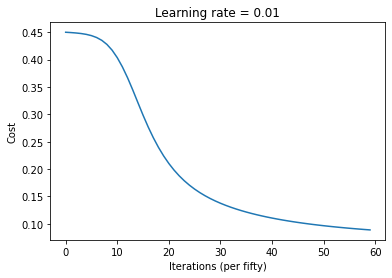

In [20]:
# TRAINING THE MODELS AND SAVING THE PARAMETERS
parameters = model(X_train, train_y, layer_dims=(n_x, n_h, n_y), num_iterations=3000, print_cost=True)

In [82]:
# ACCURACY ON THE TRAINING SET 
prediction_test, train_probas = predict(X_train, Y_train, parameters)

Accuracy: 0.8905666666666666


In [83]:
# ACCURACY ON THE TEST SET
prediction_test, test_probas = predict(X_test, Y_test, parameters)

Accuracy: 0.8958


## Checking the model with the test inputs

Here we can see that the eigth element in the output array has the maximum probability of 0.98515, which means the digit is 7 (indexing starting from 0 to 9). Plotting the image of the same first input in the test set. The image below confirms that the number in the image is indeed 7.

In [84]:
# checking the first output in the test set
test_probas[:, 0]

array([3.90916742e-04, 1.56743999e-06, 1.42322737e-04, 1.26405000e-03,
       5.69609031e-05, 1.24897183e-04, 1.28261730e-06, 9.85157167e-01,
       1.86806409e-04, 1.26740285e-02])

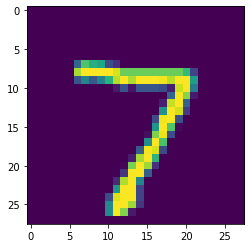

In [85]:
# plotting the first input of the test set
imshow((X_test[:, 0].reshape(28,28)));

Here we can see that the third element in the output array has the maximum probability of 0.7435, which means the digit is 2. The second highest probability is for the 6, with the value equal to 0.149, about 15%. This might be because of the straight line going diagonally which is kind of similar for the digit 2 and 6. Since both of the digits resemble a little due to their shared characteristics, it is showing 15% chances of the number being 6.

In [86]:
# checking the second output  in the test set
test_probas[:, 1]

array([2.18202037e-02, 2.29138506e-04, 7.43525885e-01, 3.69118687e-02,
       7.63664673e-06, 2.76262836e-02, 1.49086355e-01, 1.06716500e-06,
       2.07862509e-02, 5.31064604e-06])

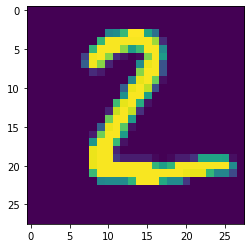

In [87]:
# plotting the second input of the test set
imshow((X_test[:, 1].reshape(28,28)));

In [88]:
# checking the 99th output  in the test set 
# ---> 0.9293 PROBABILITY THAT THE DIGIT IS 6 (MAXIMUM VALUE AT INDEX 7)
test_probas[:, 98]

array([3.53076520e-02, 3.87123212e-06, 1.96615881e-02, 5.15492135e-05,
       6.02365850e-04, 1.19056254e-02, 9.29384770e-01, 2.44565354e-06,
       3.03555900e-03, 4.45734732e-05])

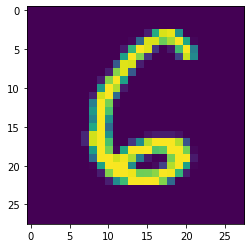

In [89]:
# plotting the 99th input of the test set
imshow((X_test[:, 98].reshape(28,28)));

Here we can see that the 100th element in the output array has the maximum probability of 0.9263 at the 10th position of the array, which means the digit is 9. And the model is correct in classifying this digit

In [90]:
# checking the 100th output  in the test set
test_probas[:, 99]

array([3.51546988e-06, 1.07801388e-06, 4.68355911e-04, 1.28550259e-04,
       3.18234061e-02, 1.83332686e-05, 2.35397749e-05, 3.95089373e-02,
       1.67931735e-03, 9.26344967e-01])

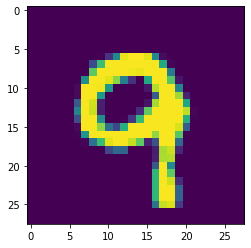

In [91]:
# plotting the 100th input of the test set
imshow((X_test[:, 99].reshape(28,28)));

In [92]:
# checking the 101th output  in the test set 
# ---> 0.8277 PROBABILITY THAT THE DIGIT IS 6 (MAXIMUM VALUE AT INDEX 7)
# ---> 0.1005 PROBABILITY THAT THE DIGIT IS 2 (SECOND MAXIMUM VALUE AT INDEX 2)
test_probas[:, 100]

array([3.09021062e-03, 1.76694727e-03, 1.00577632e-01, 1.13913684e-03,
       3.80583809e-02, 3.98703033e-03, 8.27750387e-01, 7.58547769e-04,
       1.77004429e-02, 5.17128398e-03])

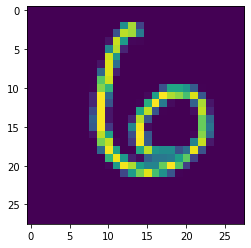

In [93]:
# plotting the 101th input of the test set
imshow((X_test[:, 100].reshape(28,28)));

In this case below, the model has made a wrong classification.
The maximum probability is for the digit 9, the value being 0.4779.
Although the model did try to predict that the digit shown was 8 because of the similarity in the way that the digit has been written, because the probability for the digit 8 is 0.2281.

In [94]:
# checking the 999th output  in the test set
test_probas[:, 998]

array([4.63805227e-03, 1.90757848e-06, 1.43717188e-03, 1.08093361e-03,
       7.45536218e-02, 1.61467496e-01, 2.67762587e-02, 2.39670298e-02,
       2.28145991e-01, 4.77931537e-01])

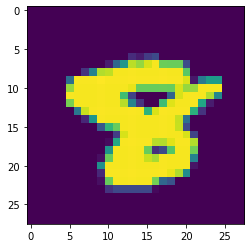

In [95]:
# plotting the 999th input of the test set
imshow((X_test[:, 998].reshape(28,28)));

In [96]:
# checking the 1000th output  in the test set
test_probas[:, 999]

array([9.68741247e-04, 4.42288842e-05, 8.84372065e-03, 1.04422644e-02,
       1.30766462e-01, 1.56956884e-03, 8.51577558e-04, 3.09252246e-01,
       4.75733743e-03, 5.32503853e-01])

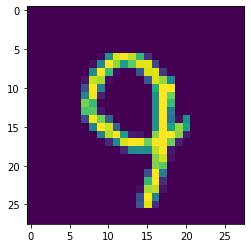

In [97]:
# plotting the 1000th input of the test set
imshow((X_test[:, 999].reshape(28,28)));

In this case below, the model has made a wrong classification.
The maximum probability is for the digit 7, the value being 0.6369.
Although the model did try to predict that the digit shown was 9, because its probability is 0.3232. This confusion might have been because of the resemblance between digit 7 and 9, which we can observe in some handwritings of different people.

In [98]:
# checking the 1001th output  in the test set
test_probas[:, 1000]

array([1.73262622e-05, 8.65941317e-04, 3.11797004e-04, 2.96299324e-02,
       4.60249697e-03, 1.25225437e-03, 2.07637537e-05, 6.36930436e-01,
       3.10414662e-03, 3.23264906e-01])

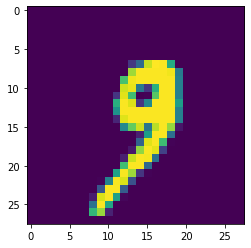

In [99]:
# plotting the 1001th input of the test set
imshow((X_test[:, 1000].reshape(28,28)));

In [100]:
# checking the 9000th output  in the test set
# correct classification of the digit zero(0) ----> PROBABILITY = 0.991
test_probas[:, 8999]

array([9.91491489e-01, 7.64015506e-10, 2.49349785e-05, 3.30077162e-05,
       1.70845041e-07, 8.37539406e-03, 6.06919779e-05, 2.39266184e-06,
       1.09250585e-05, 9.93172174e-07])

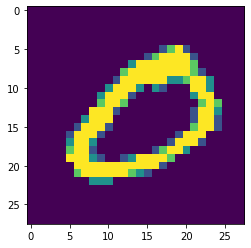

In [101]:
# plotting the 9000th input of the test set
imshow((X_test[:, 8999].reshape(28,28)));

In [102]:
# checking the 9001th output  in the test set
# CORRECT CLASSIFICATION OF DIGIT 7 --> PROBABILITY = 0.989
test_probas[:, 9000]

array([9.54343684e-05, 2.04316362e-07, 1.24272761e-05, 3.26800182e-05,
       3.89342473e-05, 3.70495127e-05, 2.92280557e-07, 9.89651797e-01,
       9.48187890e-05, 1.00363618e-02])

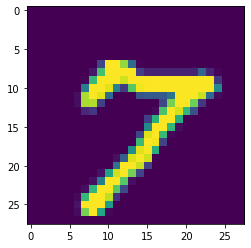

In [103]:
# plotting the 9001th input of the test set
imshow((X_test[:, 9000].reshape(28,28)));

In [106]:
# checking the 10000th output  in the test set
# correct classification of digit 6 ----> probability = 0.9979
test_probas[:, 9999]

array([6.67364661e-04, 5.82725903e-10, 1.25921515e-03, 5.40481615e-08,
       2.87872434e-05, 3.35559696e-05, 9.97997227e-01, 3.09666771e-09,
       1.32987119e-05, 4.93714154e-07])

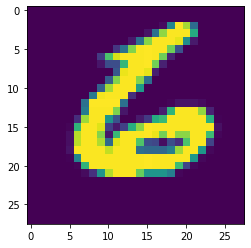

In [107]:
# plotting the 10000th input of the test set
imshow((X_test[:, 9999].reshape(28,28)));